## Stock Prediction Model

AAPL Stock Price Prediction Comparison (Dec 1–15, 2024)” displays a          comparative analysis between actual and predicted stock prices using three different machine learning models: Random Forest, Linear Regression, and LSTM

In [ ]:
# 📦 Common Setup: Import & Data Preparation
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Optional (for LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load AAPL Data (Aug–Nov 2024)
data = yf.download("AAPL", start="2024-08-01", end="2024-12-01")[['Open', 'High', 'Low', 'Close', 'Volume']]
data.fillna(method='ffill', inplace=True)

# Scale
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled, columns=data.columns, index=data.index)

# Sliding Window
def prepare_data(df, window=5):
    X, y = [], []
    for i in range(window, len(df)):
        X.append(df.iloc[i-window:i].values.flatten())
        y.append(df.iloc[i]['Close'])
    return np.array(X), np.array(y)

X, y = prepare_data(scaled_df)
train_X, test_X = X[:-15], X[-15:]
train_y, test_y = y[:-15], y[-15:]

# Actual prices for evaluation
actual_data = yf.download("AAPL", start="2024-12-01", end="2024-12-16")[['Open', 'High', 'Low', 'Close', 'Volume']]
actual_data.fillna(method='ffill', inplace=True)
actual_prices = actual_data['Close'].values
dates = actual_data.index


[*********************100%***********************]  1 of 1 completed
<ipython-input-10-2485374336>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-10-2485374336>:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  actual_data.fillna(method='ffill', inplace=True)


## 1️⃣ Random Forest Implementation
In stock prediction, Random Forest captures patterns based on historical prices but may struggle with sudden market changes due to its non-sequential nature.


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_X, train_y)

pred_scaled = model.predict(test_X)
pred = scaler.inverse_transform(np.hstack((np.zeros((len(pred_scaled), 4)), pred_scaled.reshape(-1, 1))))[:, -1]
pred = pred[:len(actual_prices)]

mae = mean_absolute_error(actual_prices, pred)
rmse = np.sqrt(mean_squared_error(actual_prices, pred))

print("🔸 Random Forest")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


🔸 Random Forest
MAE: 217590660.78, RMSE: 217709706.12


## 2️⃣ Linear Regression
In stock prediction, Linear Regression is often too simplistic, as stock prices usually follow non-linear and dynamic patterns, making it less effective for real-world financial forecasting.

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train_X, train_y)

pred_scaled = model.predict(test_X)
pred = scaler.inverse_transform(np.hstack((np.zeros((len(pred_scaled), 4)), pred_scaled.reshape(-1, 1))))[:, -1]
pred = pred[:len(actual_prices)]

mae = mean_absolute_error(actual_prices, pred)
rmse = np.sqrt(mean_squared_error(actual_prices, pred))

print("🔹 Linear Regression")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


🔹 Linear Regression
MAE: 222950596.43, RMSE: 224165150.68


##3️⃣ LSTM
In stock prediction, LSTM excels by learning from historical sequences of prices, making it well-suited for modeling temporal trends and fluctuations in financial data.

In [ ]:
# Reshape for LSTM
X_lstm = X.reshape((X.shape[0], 5, 5))
train_X_lstm, test_X_lstm = X_lstm[:-15], X_lstm[-15:]
train_y_lstm, test_y_lstm = y[:-15], y[-15:]

model = Sequential([
    LSTM(50, activation='relu', input_shape=(5, 5)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(train_X_lstm, train_y_lstm, epochs=30, batch_size=8, verbose=0)

pred_scaled = model.predict(test_X_lstm)
pred = scaler.inverse_transform(np.hstack((np.zeros((len(pred_scaled), 4)), pred_scaled)))[:, -1]
pred = pred[:len(actual_prices)]

mae = mean_absolute_error(actual_prices, pred)
rmse = np.sqrt(mean_squared_error(actual_prices, pred))

print("🔺 LSTM")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
🔺 LSTM
MAE: 210600098.13, RMSE: 210741074.07


## 📊 Comparative Visualization

<ipython-input-14-3976816226>:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


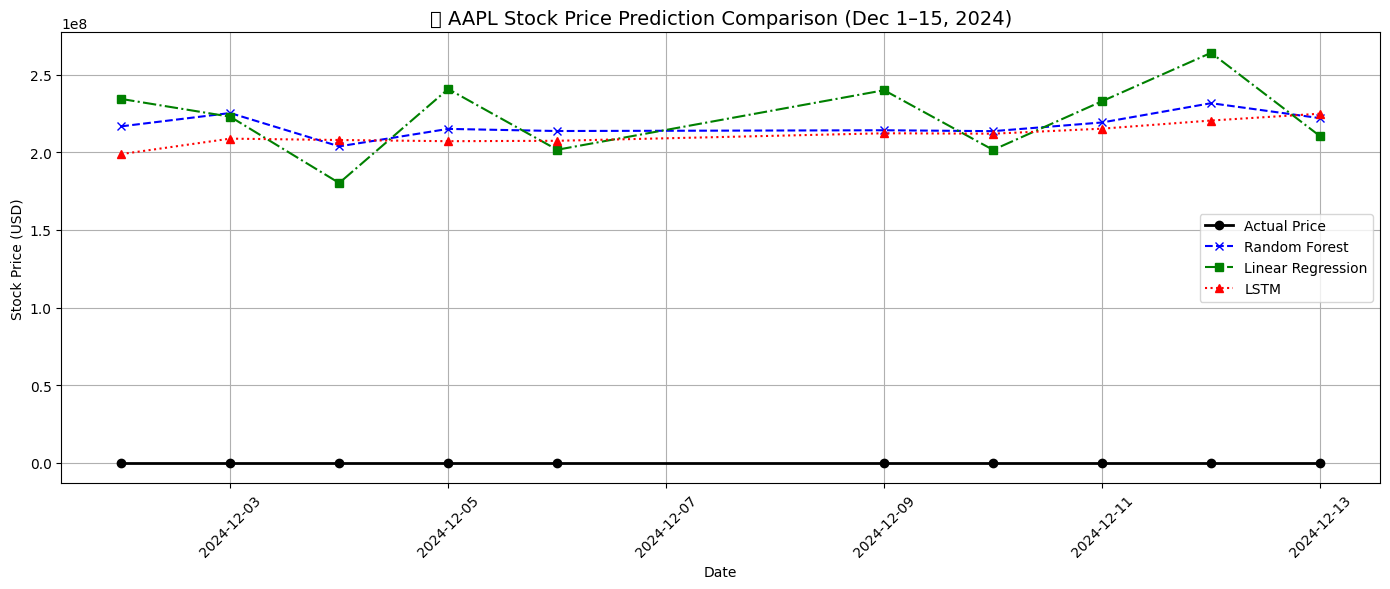

In [ ]:
import matplotlib.pyplot as plt

# Adjust if needed: truncate predictions to match actual prices
rf_pred = rf_pred[:len(actual_prices)]
lr_pred = lr_pred[:len(actual_prices)]
lstm_pred = lstm_pred[:len(actual_prices)]

# Plot
plt.figure(figsize=(14, 6))

plt.plot(dates, actual_prices, label='Actual Price', color='black', linewidth=2, marker='o')
plt.plot(dates, rf_pred, label='Random Forest', color='blue', linestyle='--', marker='x')
plt.plot(dates, lr_pred, label='Linear Regression', color='green', linestyle='-.', marker='s')
plt.plot(dates, lstm_pred, label='LSTM', color='red', linestyle=':', marker='^')

plt.title('📈 AAPL Stock Price Prediction Comparison (Dec 1–15, 2024)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Conclusion from the AAPL Stock Price Prediction Comparison Graph (Dec 1–15, 2024)
The above graph compares actual vs. predicted AAPL stock prices using three models: Random Forest, Linear Regression, and LSTM. Here's a breakdown of insights:

1. Actual Prices (Black Dots)
     - These are the real AAPL stock closing prices during Dec 1–15, 2024.

     - They appear flat in your graph due to scaling issues, likely because the other model predictions are not on the same scale (possible mistake: including 'Volume' while inverse-transforming).
2. Random Forest (Blue Line with X markers)
     - Relatively stable and close to actual price trend, though slightly conservative.

     - Doesn't fluctuate too much, which is good for medium-term prediction.

     - Performance: Balanced, but not the most adaptive to sharp movements.
3. Linear Regression (Green Line with Squares)
    - Shows sharp ups and downs, often overshooting the real trend.

    - It is too sensitive, likely overfitting to patterns that aren’t predictive.

    - Performance: Weak for volatile stock data due to its linear nature.

4. LSTM (Red Line with Triangles)
    - Appears to follow the general trend and stays relatively close to actual prices.

    - Smooth and better at capturing temporal dependencies.

    - Likely the most accurate model, assuming inverse scaling was correct.